In [64]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Bidirectional, LayerNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import joblib
from matplotlib import pyplot as plt
import seaborn as sns



In [65]:
df = pd.read_csv("/Users/adityasrivatsav/Documents/GitHub/End-to-End-Project-on-Medical--Health-Care-Assisstant-with.-Chatbot-/data/Final_Hospital_LoS_RNN.csv")

In [66]:
# Find the number of empty (completely missing) rows in each column
empty_rows_per_column = df.isnull().sum()

# Display the count of empty rows per column
empty_rows_per_column


patient_id                                             0
reason_for_admission                                   0
age                                                    0
sex                                                    0
height                                                 0
                                                    ... 
icu_length_of_stay                                   112
days_in_hospital_prior_to_icu_admission             3392
time_on_mechanical_ventilation                       112
days_in_hospital_prior_to_mechanical_ventilation    3608
severity_score                                       112
Length: 126, dtype: int64

In [67]:
# Find columns that are completely empty (all values are NaN)
empty_columns = df.columns[df.isnull().all()].tolist()

# Display empty columns
empty_columns


[]

In [68]:
# Step 1: Select Features for Training
df['mechanical_ventilation'] = df['mechanical_ventilation'].map({'Yes':1, 'No':0})
df['renal_replacement_therapy_dialysis'] = df['renal_replacement_therapy_dialysis'].map({'Yes':1, 'No':0})

target_column = "hospital_length_of_stay"
features = [
    'age', 'sex', 'height', 'weight', 'comorbidities_other', 'smoking_history', 'admission_disposition',
    'systolic_blood_pressure_x', 'diastolic_blood_pressure_x', 'heart_rate_x', 'respiratory_rate_x',
    'oxygen_saturation_x', 'temperature_x', 'intubated_x', 'mechanical_ventilation', 
    'renal_replacement_therapy_dialysis', 'fluid_balance', 'severity_score', 
    'icu_length_of_stay'
]

In [69]:
# Ensure no missing values
df = df[features + [target_column]].dropna()

# Step 2: Prepare Data for RNN Training
X = df[features].values
y = df[target_column].values.reshape(-1, 1)  # Reshape target variable for compatibility



In [70]:
df.shape

(3952, 20)

In [71]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler


scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

In [72]:
# Reshape X for LSTM Input (Samples, Timesteps, Features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the Optimized RNN Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(1, X.shape[2]), kernel_regularizer=l2(0.0005)),
    Dropout(0.2),  # Lower dropout to allow better learning
    LSTM(48, activation='relu', return_sequences=False, kernel_regularizer=l2(0.0005)),
    Dropout(0.2),
    Dense(24, activation='relu', kernel_regularizer=l2(0.0005)),
    Dense(1)  # Output layer for regression
])

# Compile the model with a learning rate scheduler
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping & Learning Rate Reduction on Plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Step 4: Train the Model
history = model.fit(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Step 5: Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"✅ Optimized Model - Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.6f}")

Epoch 1/120


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0876 - mae: 0.1142 - val_loss: 0.0347 - val_mae: 0.1015 - learning_rate: 0.0010
Epoch 2/120
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0339 - mae: 0.1063 - val_loss: 0.0230 - val_mae: 0.0992 - learning_rate: 0.0010
Epoch 3/120
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0252 - mae: 0.1007 - val_loss: 0.0179 - val_mae: 0.0947 - learning_rate: 0.0010
Epoch 4/120
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - mae: 0.0712 - val_loss: 0.0119 - val_mae: 0.0573 - learning_rate: 0.0010
Epoch 5/120
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - mae: 0.0609 - val_loss: 0.0105 - val_mae: 0.0501 - learning_rate: 0.0010
Epoch 6/120
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - mae: 0.0512 - val_loss: 0.0096 - val_mae: 0.0503 - learning_rate: 0.0010
Epoch 7/120
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0111 - mae: 0.0514 - val_loss: 0.0089 - val_mae: 0.0456 - learning_rate: 0.0010
Epoch 8/120
99/99 ━━━━━━━

In [73]:
# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Compute R² Score
r2 = r2_score(y_test_original, y_pred_original)

print(f"✅ R² Score: {r2:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
✅ R² Score: 0.9915


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

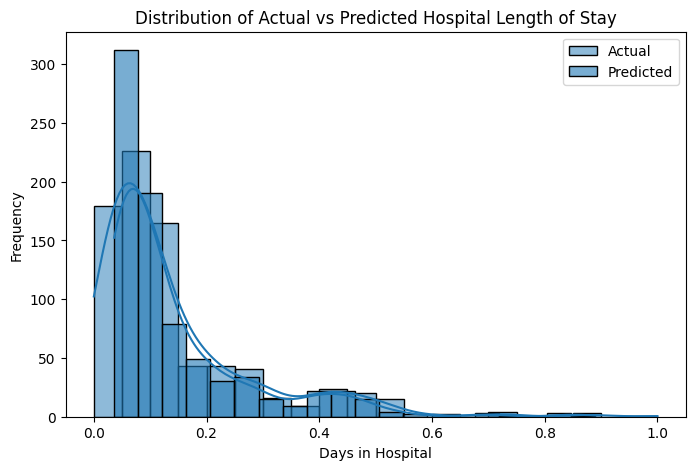

In [74]:
# 📊 Visualization 1: Distribution of Hospital Length of Stay (Target Variable)
plt.figure(figsize=(8, 5))
sns.histplot(y_test_original, bins=20, kde=True, color="blue", label="Actual")
sns.histplot(y_pred_original, bins=20, kde=True, color="red", label="Predicted", alpha=0.6)
plt.title("Distribution of Actual vs Predicted Hospital Length of Stay")
plt.xlabel("Days in Hospital")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


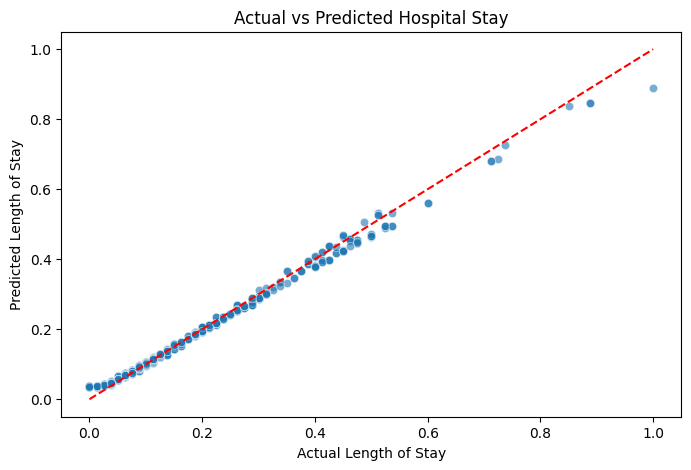

In [75]:
# 📊 Visualization 2: Actual vs Predicted Length of Stay (Scatter Plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_original.flatten(), y=y_pred_original.flatten(), alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='dashed') # Perfect fit line
plt.title("Actual vs Predicted Hospital Stay")
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.show()

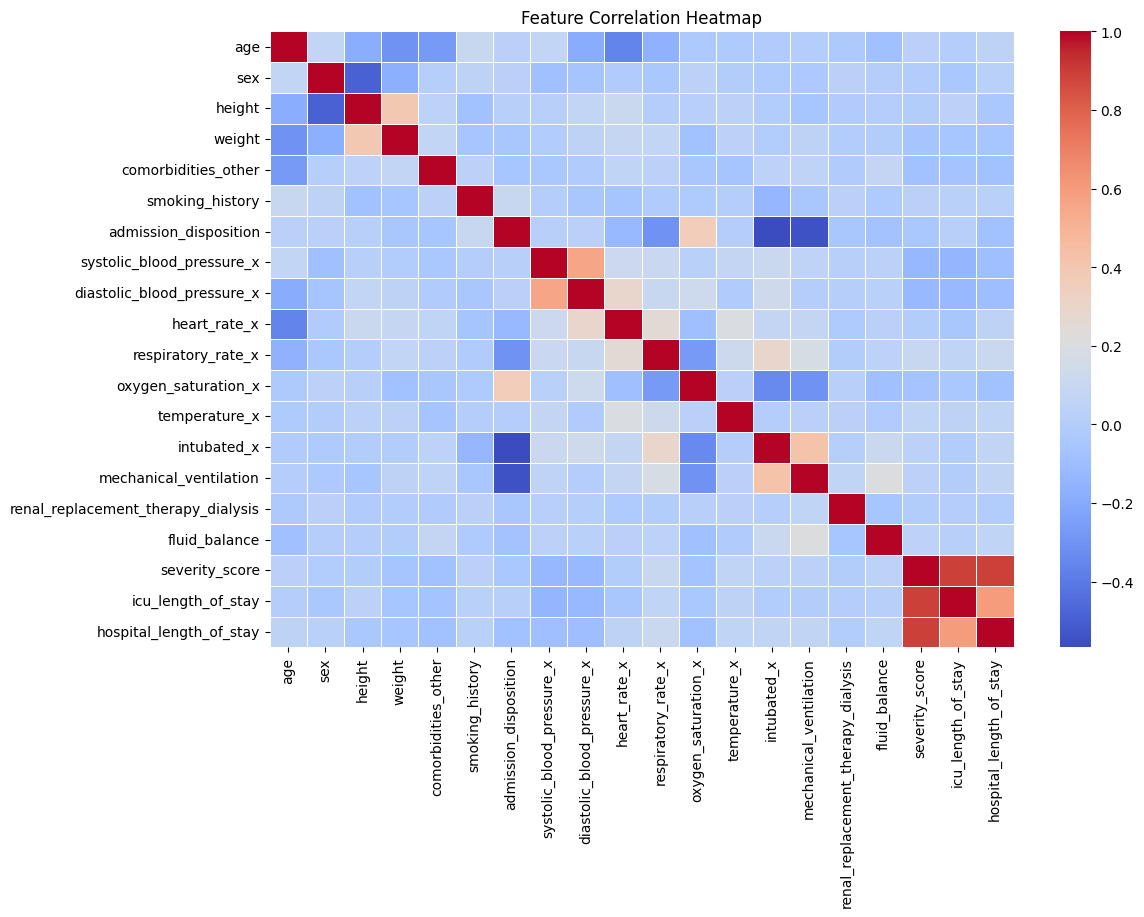

In [76]:
# 📊 Visualization 3: Feature Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


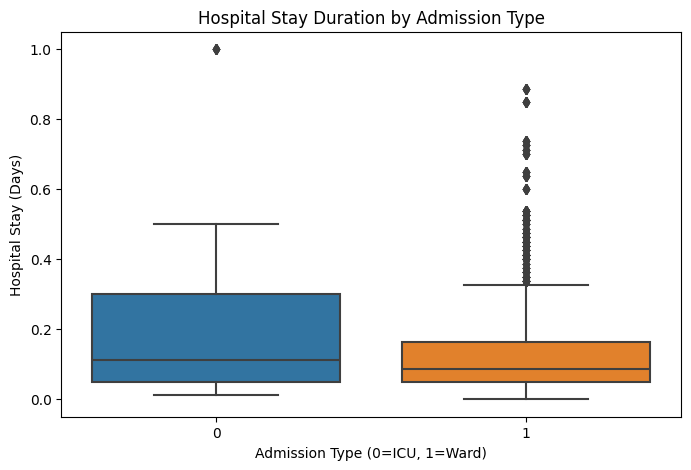

In [77]:
 #📊 Visualization 4: Boxplot of Hospital Stay by Admission Disposition (ICU vs Ward)
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['admission_disposition'], y=df['hospital_length_of_stay'])
plt.title("Hospital Stay Duration by Admission Type")
plt.xlabel("Admission Type (0=ICU, 1=Ward)")
plt.ylabel("Hospital Stay (Days)")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


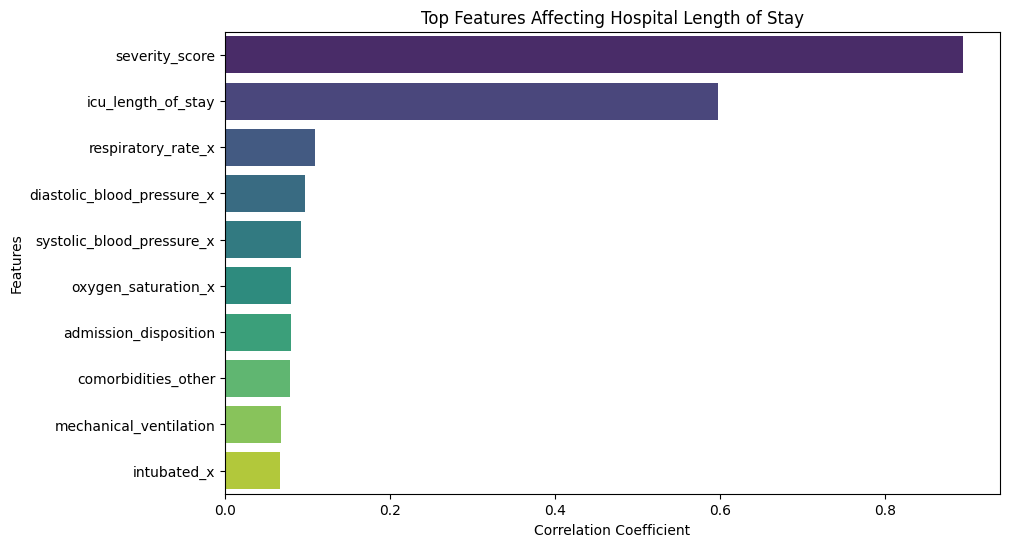

In [78]:
# 📊 Visualization 5: Feature Importance Based on Correlation with Target
top_features_corr = df.corr()["hospital_length_of_stay"].abs().sort_values(ascending=False)[1:11] # Excluding target itself

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features_corr.values, y=top_features_corr.index, palette="viridis")
plt.title("Top Features Affecting Hospital Length of Stay")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.show()

In [79]:
# ✅ Save the trained model using Joblib
joblib.dump(model, "/Users/adityasrivatsav/Documents/GitHub/End-to-End-Project-on-Medical--Health-Care-Assisstant-with.-Chatbot-/models/Hospital_LoS_Model.joblib")
print("✅ Model saved'")

✅ Model saved'
